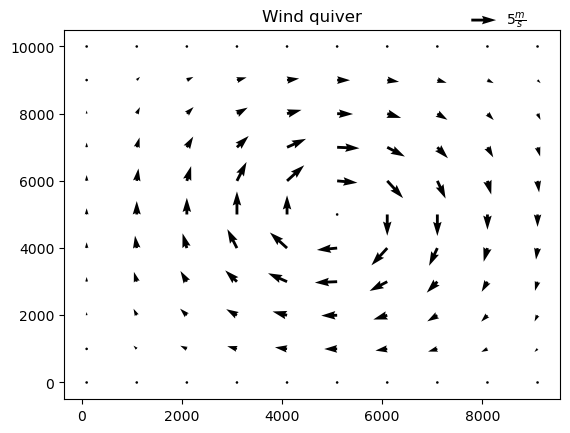

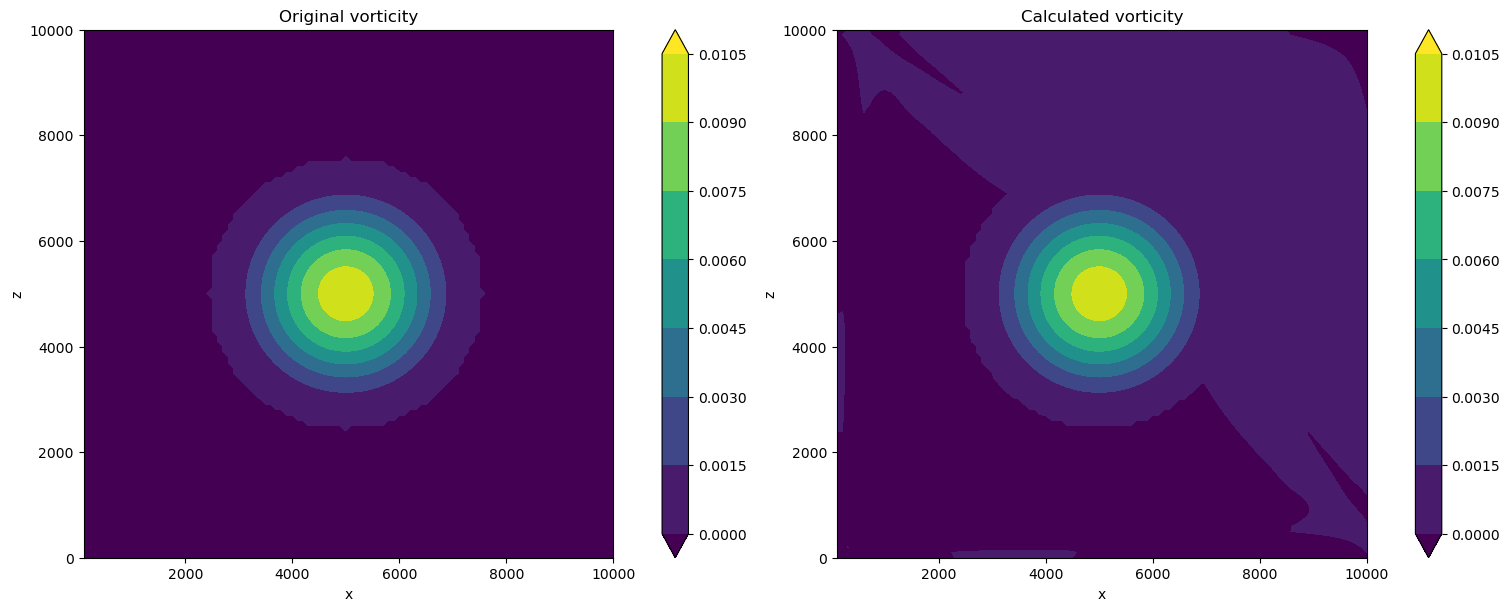

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
H = 10000  # Depth of the domain
L = 10000  # Width of the domain
dx = 100  # Grid spacing in x-direction
dz = 100  # Grid spacing in z-direction
#
# Using 2 extra column for lateral boundary conditions
nx = int(L / dx) + 3  # Number of grid points in x
nz = int(H / dz) + 1  # Number of grid points in z

# Create grid
x = np.linspace(0, L + dx * 2, nx)  # x direction grid, including extra boundary points
z = np.linspace(0, H, nz)  # y direction grid
X, Z = np.meshgrid(x, z)

# Initialize stream function and vorticity arrays
psi = np.zeros((nz, nx))  # stream function
eta = np.zeros((nz, nx))  # original vorticity
eta_c = np.zeros((nz, nx))  # calculated vorticity

# Boundary conditions for stream function
psi[0, :] = 0  # Bottom boundary
psi[-1, :] = 0  # Top boundary

# Initial vorticity distribution
eta0 = 0.01  # s^-1
R = H / 4
for i in range(1, nz - 1, 1):
    for j in range(2, nx - 2, 1):
        r = np.sqrt((X[i, j] - L / 2) ** 2 + (Z[i, j] - H / 2) ** 2)
        if r <= R:
            eta[i, j] = eta0 * np.cos(np.pi * r / (2 * R)) ** 2
        else:
            eta[i, j] = 0


# Function to apply boundary conditions for u
def apply_boundary_conditions(u):
    u[0, :] = u[-1, :] = 0  # Top boundary (rigid lid)
    u[:, 0] = u[:, nx - 2]  # Periodic boundary conditions
    u[:, nx - 1] = u[:, 1]  # Periodic boundary conditions
    return u


# Solve for stream function psi using SOR method
def solve_stream_function(max_iterations, dz, dx, nz, nx, eta, psi):
    # INPUT
    # dz, dx: grid spacing
    # nz, nx: grid number
    # eta: original vorticiy
    # psi: the first guess of stream function
    #
    # OUTPUT
    # psi: updated stream function
    #
    # Calculate coefficients for R
    cx = dz**2 / (2 * (dx**2 + dz**2))
    cz = dx**2 / (2 * (dx**2 + dz**2))
    C = (dx**2 * dz**2) / (2 * (dx**2 + dz**2))

    # Calculate alpha
    # Using the grid interval calculate t_m
    # For x direction only calculate in physical domain without extra boundary points.
    t_m = np.cos(np.pi / (nx - 3)) + np.cos(np.pi / (nz - 1))
    alpha = (8.0 - 4.0 * np.sqrt(4.0 - t_m**2.0)) / t_m**2.0

    for i in np.arange(2, nx - 2, 1):
        for k in np.arange(1, nz - 1, 1):
            R = (
                cx * (psi[k, i + 1] + psi[k, i - 1])
                + cz * (psi[k + 1, i] + psi[k - 1, i])
                - C * eta[k, i]
                - psi[k, i]
            )
            psi[k, i] = psi[k, i] + alpha * R
    # Call apply lateral boundary conditions
    apply_boundary_conditions(psi)

    return psi


# Main loop for call function and calculate the stream function
max_iterations = 200
for iteration in range(max_iterations):
    solve_stream_function(dz, dx, nz, nx, eta, psi)

# Central difference scheme
# Calculate the vorticity by del^psi=eta
for i in np.arange(2, nx - 2, 1):
    for k in np.arange(1, nz - 1, 1):
        eta_c[k, i] = (psi[k + 1, i] - 2 * psi[k, i] + psi[k - 1, i]) / dz**2 + (
            psi[k, i + 1] - 2 * psi[k, i] + psi[k, i - 1]
        ) / dx**2
# Call apply lateral boundary conditions
eta_c = apply_boundary_conditions(eta_c)

# Compute velocity components from stream function
u = np.zeros_like(psi)
w = np.zeros_like(psi)
u[1:-1, :] = (psi[2:, :] - psi[:-2, :]) / (2 * dz)
w[:, 1:-1] = -(psi[:, 2:] - psi[:, :-2]) / (2 * dx)
# Apply boundary conditions
u = apply_boundary_conditions(u)
w = apply_boundary_conditions(w)

# Plot the velocity vector as quiver map
plt.figure()
plt.title("Wind quiver")
q = plt.quiver(
    X[::10, 1:-2:10],
    Z[::10, 1:-2:10],
    u[::10, 1:-2:10],
    w[::10, 1:-2:10],
    scale=100,
    units="width",
)
qk = plt.quiverkey(
    q, 0.8, 0.9, 5, r"$5 \frac{m}{s}$", labelpos="E", coordinates="figure"
)

# Plot the vorticity result as 2d map
fig, ax = plt.subplots(1, 2, layout="constrained", figsize=(15, 6))
# Original vorticity
p = ax[0].contourf(
    X[:, 1:-2],
    Z[:, 1:-2],
    eta[:, 1:-2],
    levels=np.arange(0.0, 0.0120, 0.0015),
    extend="both",
)
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")
ax[0].set_title("Original vorticity")
# Calculated vorticity
e = ax[1].contourf(
    X[:, 1:-2],
    Z[:, 1:-2],
    eta_c[:, 1:-2],
    levels=np.arange(0.0, 0.0120, 0.0015),
    extend="both",
)
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
ax[1].set_title("Calculated vorticity")
fig.colorbar(p, ax=ax[0])
fig.colorbar(e, ax=ax[1])